<h1 style="font-size:2.5em; color:#f5a442;">Machine Learning [4483] Project: A second
hand car price prediction
system with additional trends and
insights</h1>

<h2 style="font-size:1.5em; color:#808080;">Kai Broux (r0745431) and Luigi Guerriero (r0760424)</h2>
<h2 style="font-size:1.0em; color:#808080;">Master's students IIW UHasselt-KULeuven Campus Diepenbeek</h2>

# 1. Introduction

The goal of our project is to make a price prediction system for used cars and to extract interesting information and insights. The price prediction model and insights can be extracted from a dataset of different used cars. The model and insights could be then later used as a tool for a second-hand car retailer to give insights to potential customers shopping for a second-hand car. Moreover, this price prediction model and insights tool may also come in handy for a customer looking to sell his/her car.

This [`dataset`](https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes) contains data from 100 000 used cars from the UK which are divided into separate brands. Each brand is divided into a separate file and contains information about the model, year, price, transmission, mileage, fuel type, road tax, mpg and engine size.

Before we begin with the project, we need to import all libraries required for this project. Throughout the course, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, and [`matplotlib`](https://matplotlib.org/) for plotting. In this assignment, we will also use [`scipy`](https://docs.scipy.org/doc/scipy/reference/), which contains scientific and numerical computation functions and tools. 

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# used for importing .csv data
import pandas as pd

# Plotting library
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D  # needed to plot 3-D surfaces

# Optimization module in scipy
from scipy import optimize

# For determining R2
from sklearn.metrics import r2_score

# Tools for extracting how much features and which features we need
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR

import scipy

import seaborn as sbn

# tells matplotlib to embed plots within the notebook
%matplotlib inline

# 2. Project itself

###  2.1 Loading in the data

As mentioned in the introduction a separate file of a car brand is stored in a `.csv` file and consist of the following columns:

    Model: Model type.
    Year: Registration Year.
    Price: Price in euros.
    Transmission: Type of Gearbos.
    Mileage: Distance Used.
    FuelType: Engine Fuel.
    Tax: Road Tax.
    mpg: Miles per Gallon.
    EngineSize: Size in litres.
    Brand: Name of the car brand.

Because the dataset also includes an abundance of information of a specefic car model, we will leave them outside of the dataset and only consider a brand with different models. Therefore we will leave out the `cclass.csv` and `focus.csv` files.

To load in the dataset, we first have to load in the separate `.csv` files. 

In [2]:
audi = pd.read_csv("dataset/audi.csv")
bmw = pd.read_csv("dataset/bmw.csv")
ford = pd.read_csv("dataset/ford.csv")
hyundai = pd.read_csv("dataset/hyundi.csv")
mercedes = pd.read_csv("dataset/merc.csv")
skoda = pd.read_csv("dataset/skoda.csv")
toyota = pd.read_csv("dataset/toyota.csv")
vauxhall = pd.read_csv("dataset/vauxhall.csv")
volkswagen = pd.read_csv("dataset/vw.csv")

We are having different datasets for different brands. So if we want to combine them we need to add an extra column to each `.csv` file describing the name of the brand :

In [3]:
audi['brand'] = 'audi'
bmw['brand'] = 'bmw'
ford['brand'] = 'ford'
hyundai['brand'] = 'hyundai'
mercedes['brand'] = 'mercedes'
skoda['brand'] = 'skoda'
toyota['brand'] = 'toyota'
vauxhall['brand'] = 'vauxhall'
volkswagen['brand'] = 'volkswagen'

df = pd.concat([audi,bmw,
               ford,hyundai,mercedes,skoda,toyota,
               vauxhall,volkswagen])
# drop the tax column
df.drop('tax(£)',axis=1,inplace=True)
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi
...,...,...,...,...,...,...,...,...,...,...
15152,Eos,2012,5990,Manual,74000,Diesel,125.0,58.9,2.0,volkswagen
15153,Fox,2008,1799,Manual,88102,Petrol,145.0,46.3,1.2,volkswagen
15154,Fox,2009,1590,Manual,70000,Petrol,200.0,42.0,1.4,volkswagen
15155,Fox,2006,1250,Manual,82704,Petrol,150.0,46.3,1.2,volkswagen


### 2.2 Lineair regression with one variable 

To start of simply, we are going to apply linear regression with one variable to determine the price of a Mercedes C-class, more specefic the W205 model. We can use the `cclass.csv` and only look to at the the C-class from years 2014-2021.

We have to first load the dataset:

In [4]:
cclass = pd.read_csv("dataset/cclass.csv")
display(cclass)

,model,year,price,transmission,mileage,fuelType,engineSize
0,C Class,2020,30495,Automatic,1200,Diesel,2.0
1,C Class,2020,29989,Automatic,1000,Petrol,1.5
2,C Class,2020,37899,Automatic,500,Diesel,2.0
3,C Class,2019,30399,Automatic,5000,Diesel,2.0
4,C Class,2019,29899,Automatic,4500,Diesel,2.0
...,...,...,...,...,...,...,...
3894,C Class,2017,14700,Manual,31357,Diesel,1.6
3895,C Class,2018,18500,Automatic,28248,Diesel,2.1
3896,C Class,2014,11900,Manual,48055,Diesel,2.1
3897,C Class,2014,11300,Automatic,49865,Diesel,2.1


First take a look at our price density to figure out if we have to trim the data:

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

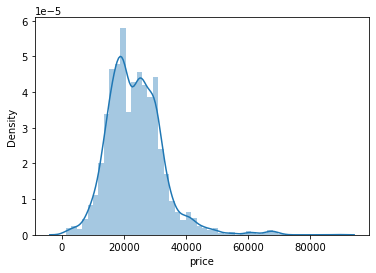

In [5]:
sbn.distplot(cclass["price"])

There are a lot of outliers above the 50000 price that do not respresent the majority of the data. So we filter out the c-classes ranging from 0-50000:

Since we want to examine the C-class W205 model we have to filter out the C-classes that are not in the 2014-2021 year-range: 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

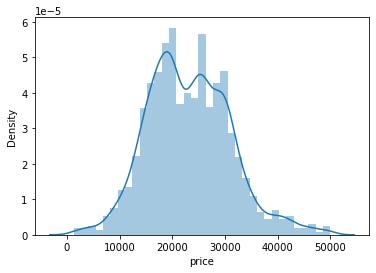

In [6]:
cclass = cclass.loc[(cclass['price'] >= 0) & (cclass['price'] <= 50000)]
sbn.distplot(cclass["price"])

In [7]:
cclass = cclass[(cclass['year'] > 2016) & (cclass['year'] < 2022)]
display(cclass)
print(len(cclass))

,model,year,price,transmission,mileage,fuelType,engineSize
0,C Class,2020,30495,Automatic,1200,Diesel,2.0
1,C Class,2020,29989,Automatic,1000,Petrol,1.5
2,C Class,2020,37899,Automatic,500,Diesel,2.0
3,C Class,2019,30399,Automatic,5000,Diesel,2.0
4,C Class,2019,29899,Automatic,4500,Diesel,2.0
...,...,...,...,...,...,...,...
3889,C Class,2017,14200,Automatic,53528,Diesel,2.1
3891,C Class,2018,23600,Automatic,18834,Petrol,2.0
3892,C Class,2018,19900,Manual,31540,Petrol,2.0
3894,C Class,2017,14700,Manual,31357,Diesel,1.6


2697


For the lineair regression with one variable, we will choose the mileage as variable (for the x-axis). The price will be selected for the y-axis. We will then visualise the data. Following function can help us to quickly plot graphs:

In [8]:
def plotData(x, y):
    fig = pyplot.figure()  # open a new figure    
    pyplot.plot(x, y, 'ro', ms=10, mec='k')
    pyplot.ylabel('Price of a W205 C-Class in £')
    pyplot.xlabel('Mileage in miles')   

[ 1200  1000   500 ... 31540 31357 28248]


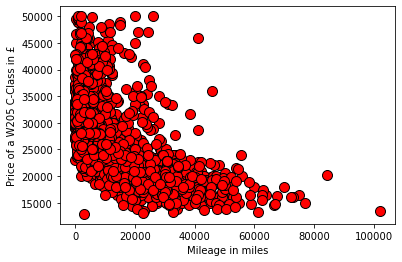

In [9]:
#X and y values of the entire dataset (for visualisation)
X_all = cclass['mileage'].to_numpy()
y_all = cclass['price'].to_numpy()
m_all = y_all.size #dataset size
print(X_all)

#Visualise data
plotData(X_all,y_all)

#### Splitting Data into CV, training and test set

In [10]:
cclass_shuffled = cclass.sample(frac=1)
cclass_shuffled.head()

,model,year,price,transmission,mileage,fuelType,engineSize
1188,C Class,2020,47980,Semi-Auto,4462,Petrol,3.0
2443,C Class,2019,25749,Semi-Auto,13873,Diesel,2.0
2626,C Class,2017,31349,Semi-Auto,16915,Petrol,3.0
583,C Class,2019,24980,Automatic,15000,Diesel,1.6
1637,C Class,2019,42895,Automatic,4829,Petrol,3.0


In [11]:
zero_60percent= int(len(cclass_shuffled)*0.6)
sixty_80percent = int(len(cclass_shuffled)*0.8)
hundred_percent = int(len(cclass_shuffled))
#print(zero_60percent)
#print(sixty_80percent)
#print(hundred_percent)
cclass_train = cclass_shuffled.iloc[0:zero_60percent]  #0-60%
cclass_CV = cclass_shuffled.iloc[zero_60percent:sixty_80percent] #20%: 60-80
cclass_test = cclass_shuffled.iloc[sixty_80percent:hundred_percent] #20%: 80-100
print(len(cclass_train),len(cclass_CV),len(cclass_test))

1618 539 540


In [12]:
#Load into X an Y
X = cclass_train['mileage'].to_numpy()
y = cclass_train['price'].to_numpy()
m = y.size #dataset size

X_CV = cclass_CV['mileage'].to_numpy()
y_CV = cclass_CV['price'].to_numpy()
m_CV = y_CV.size

X_test = cclass_test['mileage'].to_numpy()
y_test = cclass_test['price'].to_numpy()
m_test = y_test.size

#### Gradient descent  

In this part, you will fit the linear regression parameters $\theta$ to our dataset using gradient descent.

The objective of linear regression is to minimize the cost function

$$ J(\theta) = \frac{1}{2m} \sum_{i=1}^m \left( h_{\theta}(x^{(i)}) - y^{(i)}\right)^2$$

where the hypothesis $h_\theta(x)$ is given by the linear model
$$ h_\theta(x) = \theta^Tx = \theta_0 + \theta_1 x_1$$

Recall that the parameters of your model are the $\theta_j$ values. These are
the values you will adjust to minimize cost $J(\theta)$. One way to do this is to
use the batch gradient descent algorithm. In batch gradient descent, each
iteration performs the update

$$ \theta_j = \theta_j - \alpha \frac{1}{m} \sum_{i=1}^m \left( h_\theta(x^{(i)}) - y^{(i)}\right)x_j^{(i)} \qquad \text{simultaneously update } \theta_j \text{ for all } j$$

With each step of gradient descent, your parameters $\theta_j$ come closer to the optimal values that will achieve the lowest cost J($\theta$).

We first want to normalize our features to make sure our gradient descent works out without any overflow problems. Besides we add a column of ones to X:

In [13]:
mu = np.mean(X, axis = 0)
sigma = np.std(X, axis = 0)
X_norm = (X - mu) / sigma
print(X_norm)

[-0.68945977  0.08769827  0.33890587 ... -0.82356928 -0.88533894
  2.32726111]


In [14]:
# Add a column of ones to X. The numpy function stack joins arrays along a given axis. 
# The first axis (axis=0) refers to rows (training examples) 
# and second axis (axis=1) refers to columns (features).


X_not_norm = X  #save original X if we need it later
X_not_norm_stacked = np.stack([np.ones(m), X_not_norm], axis=1)  #column of ones to X
X  = np.stack([np.ones(m), X_norm], axis=1)                      #column of ones to the normalized X
print("A column of ones to X-normalized:\n", X)
print("\nA column of ones to not normalized X:\n",X_not_norm_stacked)


A column of ones to X-normalized:
 [[ 1.         -0.68945977]
 [ 1.          0.08769827]
 [ 1.          0.33890587]
 ...
 [ 1.         -0.82356928]
 [ 1.         -0.88533894]
 [ 1.          2.32726111]]

A column of ones to not normalized X:
 [[1.0000e+00 4.4620e+03]
 [1.0000e+00 1.3873e+04]
 [1.0000e+00 1.6915e+04]
 ...
 [1.0000e+00 2.8380e+03]
 [1.0000e+00 2.0900e+03]
 [1.0000e+00 4.0993e+04]]


For the cost function we can define a function that determines the cost:

In [15]:
def computeCost(X, y, theta):
     
    # initialize some useful values
    m = y.size  # number of training examples
    
    # You need to return the following variables correctly
    J = 0
    
    h= np.dot(X,theta)
    inner = (h-y)**2
    J = (1/(2*m)) * (np.sum(inner))

    return J

For Gradient descent we can define following function:

In [16]:
def gradientDescent(X, y, theta, alpha, num_iters):
    # Initialize some useful values
    m = y.shape[0]  # number of training examples
    
    # make a copy of theta, to avoid changing the original array, since numpy arrays
    # are passed by reference to functions
    theta = theta.copy()
    
    J_history = [] # Use a python list to save cost in every iteration
    
    for i in range(num_iters):
        # ==================== YOUR CODE HERE =================================
        theta = theta - (alpha / m) * (np.dot(X, theta) - y).dot(X)

        # =====================================================================
        
        # save the cost J in every iteration
        J_history.append(computeCost(X, y, theta))
    
    return theta, J_history



We initialize the 𝜃 parameters to 0 and the learning rate 𝛼 to 0.01 and use the final parameters to plot the lineair fit:

In [17]:
# initialize fitting parameters
theta = np.zeros(2)

# some gradient descent settings
iterations = 100000
alpha = 1

theta, J_history = gradientDescent(X ,y, theta, alpha, iterations)
print('Theta found by gradient descent: {:.4f}, {:.4f}'.format(*theta))

Theta found by gradient descent: 26586.6928, -3991.8300


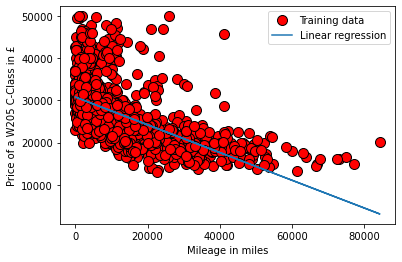

In [18]:
# plot the linear fit
plotData(X_not_norm_stacked[:, 1], y)
pyplot.plot(X_not_norm_stacked[:, 1], np.dot(X, theta), '-')
pyplot.legend(['Training data', 'Linear regression']);

## Regularised linear regression

In [19]:
def linearRegCostFunction(X, y, theta, lambda_=0.0):
    
    # Initialize some useful values
    m = y.size # number of training examples
    # You need to return the following variables correctly 
    J = 0
    grad = np.zeros(theta.shape)

    # ====================== YOUR CODE HERE ======================
    
    h= np.dot(X,theta)   
    J = (1/(2*m)) * (np.sum((h-y)**2)) + (lambda_/(2*m))*(np.sum(theta[1:]**2))   
    grad = (1 / m) * (h - y).dot(X)
    grad[1:] = grad[1:] + (lambda_ / m) * theta[1:]

    # ============================================================
    return J, grad

def trainLinearReg(linearRegCostFunction, X, y, lambda_=0.0, maxiter=200):
    """
    Trains linear regression using scipy's optimize.minimize.

    Parameters
    ----------
    X : array_like
        The dataset with shape (m x n+1). The bias term is assumed to be concatenated.

    y : array_like
        Function values at each datapoint. A vector of shape (m,).

    lambda_ : float, optional
        The regularization parameter.

    maxiter : int, optional
        Maximum number of iteration for the optimization algorithm.

    Returns
    -------
    theta : array_like
        The parameters for linear regression. This is a vector of shape (n+1,).
    """
    # Initialize Theta
    initial_theta = np.zeros(X.shape[1])

    # Create "short hand" for the cost function to be minimized
    costFunction = lambda t: linearRegCostFunction(X, y, t, lambda_)

    # Now, costFunction is a function that takes in only one argument
    options = {'maxiter': maxiter}

    # Minimize using scipy
    res = optimize.minimize(costFunction, initial_theta, jac=True, method='TNC', options=options)
    return res.x

#### Selecting $\lambda$ using a cross validation set

In [20]:
def validationCurve(X, y, Xval, yval):
    # Selected values of lambda (you should not change this)
    lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

    # You need to return these variables correctly.
    error_train = np.zeros(len(lambda_vec))
    error_val = np.zeros(len(lambda_vec))

    # ====================== YOUR CODE HERE ======================
    
    for i in range(len(lambda_vec)):
        lambda_try = lambda_vec[i]
        theta_t = trainLinearReg(linearRegCostFunction, X, y, lambda_ = lambda_try)
        error_train[i], _ = linearRegCostFunction(X, y, theta_t, lambda_ = 0)
        error_val[i], _ = linearRegCostFunction(Xval, yval, theta_t, lambda_ = 0)



    # ============================================================
    return lambda_vec, error_train, error_val

Since we haven't normalized out features from our cross validation set, we have to do it first before proceeding:

In [21]:
X_CV = np.array(X_CV).reshape(np.array(X_CV).size,1)
mu_CV = np.mean(X_CV, axis = 0)
sigma_CV = np.std(X_CV, axis = 0)
X_CV_norm = (X_CV - mu_CV) / sigma_CV
X_CV_norm_stacked  = np.concatenate([np.ones((y_CV.size,1)), X_CV_norm], axis=1)
print(X_CV_norm_stacked)
#print(X_CV_norm)
#print(m_CV)
#print(np.ones((y_CV.size,1)))

[[ 1.00000000e+00 -7.21553980e-01]
 [ 1.00000000e+00 -5.50692159e-01]
 [ 1.00000000e+00  5.51502457e-01]
 ...
 [ 1.00000000e+00 -1.04366078e+00]
 [ 1.00000000e+00 -9.11132379e-04]
 [ 1.00000000e+00  6.71751134e-01]]


lambda		Train Error	Validation Error
 0.000000	13845684.818687	12104870.969236
 0.001000	13845684.818690	12104870.640679
 0.003000	13845684.818714	12104869.983583
 0.010000	13845684.818991	12104867.683953
 0.030000	13845684.821426	12104861.115336
 0.100000	13845684.849117	12104838.145621
 0.300000	13845685.092490	12104772.693084
 1.000000	13845687.858315	12104545.651049
 3.000000	13845712.107878	12103914.400346
 10.000000	13845985.429973	12101906.155106


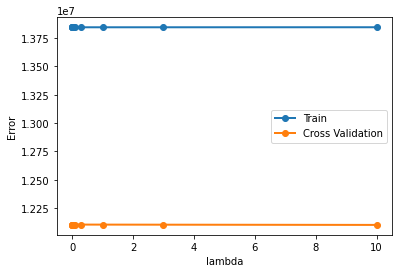

In [22]:
lambda_vec, error_train, error_val = validationCurve(X, y, X_CV_norm_stacked, y_CV)

pyplot.plot(lambda_vec, error_train, '-o', lambda_vec, error_val, '-o', lw=2)
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('lambda')
pyplot.ylabel('Error')

print('lambda\t\tTrain Error\tValidation Error')
for i in range(len(lambda_vec)):
    print(' %f\t%f\t%f' % (lambda_vec[i], error_train[i], error_val[i]))

#### Regularised linear regression with our chosen $\lambda$ 

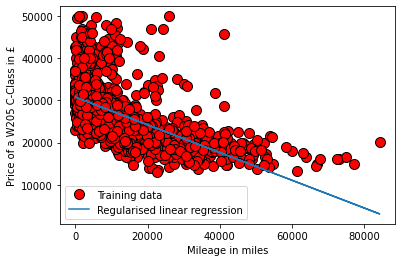

In [23]:
theta_regularized = trainLinearReg(linearRegCostFunction, X, y, lambda_=0)
# plot the linear fit
plotData(X_not_norm_stacked[:, 1], y)
pyplot.plot(X_not_norm_stacked[:, 1], np.dot(X, theta_regularized), '-')
pyplot.legend(['Training data', 'Regularised linear regression']);

In [24]:
y_pred = np.dot(X, theta_regularized)
#print(y_pred)
#print(y)
print("R² score of linear regression model: ",r2_score(y, y_pred))

R² score of linear regression model:  0.36525647203152745


### Learning curve

In [25]:
def learningCurve(X, y, Xval, yval, lambda_=0):
    # Number of training examples
    m = y.size

    # You need to return these values correctly
    error_train = np.zeros(m)
    error_val   = np.zeros(m)

    # ====================== YOUR CODE HERE ======================
    for i in range(1, m+1):
        theta_t = trainLinearReg(linearRegCostFunction, X[:i], y[:i], lambda_ = lambda_)
        error_train[i - 1], _ = linearRegCostFunction(X[:i], y[:i], theta_t, lambda_ = 0)
        error_val[i - 1], _ = linearRegCostFunction(Xval, yval, theta_t, lambda_ = 0)

        
    # =============================================================
    return error_train, error_val

We still need to add ones for the X_CV set

In [26]:
#mu_CV = np.mean(X_CV, axis = 0)
#sigma_CV = np.std(X_CV, axis = 0)
#X_CV_norm = (X_CV - mu_CV) / sigma_CV

X_CV_with_ones = np.concatenate([np.ones((y_CV.size,1)), X_CV], axis=1)
print(X_CV_with_ones)
print(X_not_norm_stacked)

[[1.0000e+00 4.7930e+03]
 [1.0000e+00 6.8050e+03]
 [1.0000e+00 1.9784e+04]
 ...
 [1.0000e+00 1.0000e+03]
 [1.0000e+00 1.3279e+04]
 [1.0000e+00 2.1200e+04]]
[[1.0000e+00 4.4620e+03]
 [1.0000e+00 1.3873e+04]
 [1.0000e+00 1.6915e+04]
 ...
 [1.0000e+00 2.8380e+03]
 [1.0000e+00 2.0900e+03]
 [1.0000e+00 4.0993e+04]]


Plot learning curve for linear regression

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	15338793774.444271
  	2		356775112.571353	688520764.709798
  	3		251301337.164787	460949915.186248
  	4		192304849.141225	392603017.948395
  	5		260656465.273395	478492175.448337
  	6		357392960.794821	216237108.075959
  	7		318438258.695753	217483727.311265
  	8		327553751.701141	218192951.588183
  	9		298750829.575926	219850593.201208
  	10		268583136.396644	219775988.588898
  	11		266702006.763332	221462726.780174
  	12		275746971.143261	217741322.097874
  	13		255779599.953180	216677593.096457
  	14		256336264.393760	216401891.871633
  	15		244734707.185723	218192579.456529
  	16		229274304.368856	218139812.400994
  	17		225018393.320506	217956516.554696
  	18		230259398.751123	217700736.375181
  	19		227143624.624404	216789696.921605
  	20		226091763.959702	216913409.260171
  	21		224347783.746008	216472026.495737
  	22		215368016.970583	216016613.681584
  	23		207642403.837277	215785518.507253
  	24		201157212.

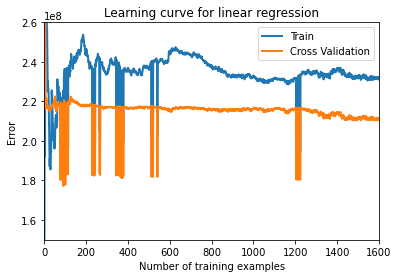

In [27]:
error_train, error_val = learningCurve(X_not_norm_stacked, y, X_CV_with_ones, y_CV, lambda_=0)
#error_train, error_val = learningCurve(X, y, X_CV_with_ones, y_CV, lambda_=0)

pyplot.plot(np.arange(1, m+1), error_train, np.arange(1, m+1), error_val, lw=2)
pyplot.title('Learning curve for linear regression')
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.axis([0, 1600, 150000000, 260000000])

print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

### Error histogram CV

[[-7.01657774e-01 -1.36552035e-05 -2.30052635e-10]
 [-5.35507315e-01 -1.04216923e-05 -1.75576860e-10]
 [ 5.36295270e-01  1.04370269e-05  1.75835207e-10]
 ...
 [-1.01488277e+00 -1.97509830e-05 -3.32749759e-10]
 [-8.86008717e-04 -1.72429207e-08 -2.90495805e-13]
 [ 6.53228197e-01  1.27126989e-05  2.14174023e-10]]
[[1.0000e+00 4.7930e+03]
 [1.0000e+00 6.8050e+03]
 [1.0000e+00 1.9784e+04]
 ...
 [1.0000e+00 1.0000e+03]
 [1.0000e+00 1.3279e+04]
 [1.0000e+00 2.1200e+04]]
[260.23545678   0.94784334]
[ 4803.24856324  6710.30935402 19012.36800388  4595.6708728
  2748.32421215 20378.21025015  6026.91430921  1208.07879216
  3008.03328604 15385.91940272  6610.78580381 20022.76899939
 15362.22331934 10284.62657173 18382.05218585 31002.58619639
  3517.02515714  4089.5225317   4272.45629543   268.7660468
 23956.3188412  24495.64169903 41036.45574469 15685.4378967
 16893.93814931 23956.3188412  33897.29974263 35789.19504004
 21165.86806185 33103.00702759  5098.02784055 21150.70256849
  1208.07879216  71

(array([56., 85., 75., 79., 78., 83., 58., 16.,  4.,  5.]),
 array([2.51340960e+01, 4.86643765e+03, 9.70774121e+03, 1.45490448e+04,
        1.93903483e+04, 2.42316519e+04, 2.90729554e+04, 3.39142590e+04,
        3.87555626e+04, 4.35968661e+04, 4.84381697e+04]),
 <BarContainer object of 10 artists>)

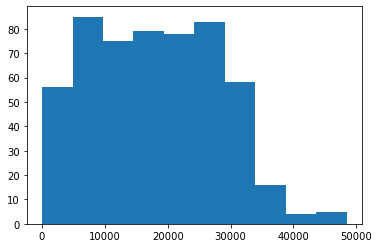

In [51]:
mu_CV = np.mean(X_CV, axis = 0)
sigma_CV = np.std(X_CV, axis = 0)
X_norm_CV = (X_CV - mu_CV) / sigma
print(X_norm_CV)

X_CV_not_norm = X_norm_CV  #save original X_CV if we need it later
#X_CV_not_norm_stacked = np.stack([np.ones(m_CV), X_CV_not_norm], axis=1)  #column of ones to X
X_CV_norm_stacked  = np.concatenate([np.ones((m_CV,1)), X_CV], axis=1)                      #column of ones to the normalized X
print(X_CV_norm_stacked)

theta_regularized_CV = trainLinearReg(linearRegCostFunction, X_CV_norm_stacked, y_CV, lambda_=0)
print(theta_regularized_CV)
y_pred_CV = np.dot(X_CV_norm_stacked, theta_regularized_CV)
print(y_pred_CV)
fout = np.abs(y_CV - y_pred_CV)
print(fout)

pyplot.hist(fout)


## Polynomial regression

The problem with our linear model was that it was too simple for the data and resulted in underfitting (high bias).

In [28]:
def polyFeatures(X, p):
    """
    Maps X (1D vector) into the p-th power.
    
    Parameters
    ----------
    X : array_like
        A data vector of size m, where m is the number of examples.
    
    p : int
        The polynomial power to map the features. 
    
    Returns 
    -------
    X_poly : array_like
        A matrix of shape (m x p) where p is the polynomial 
        power and m is the number of examples. That is:
    
        X_poly[i, :] = [X[i], X[i]**2, X[i]**3 ...  X[i]**p]
    
    Instructions
    ------------
    Given a vector X, return a matrix X_poly where the p-th column of
    X contains the values of X to the p-th power.
    """
    # You need to return the following variables correctly.
    X_poly = np.zeros((X.shape[0], p))

    # ====================== YOUR CODE HERE ======================

    for i in range(p):
        X_poly[:, i] = X[:, 0] ** (i + 1)

    # ============================================================
    return X_poly

def plotFit(polyFeatures, min_x, max_x, mu, sigma, theta, p):
    """
    Plots a learned polynomial regression fit over an existing figure.
    Also works with linear regression.
    Plots the learned polynomial fit with power p and feature normalization (mu, sigma).

    Parameters
    ----------
    polyFeatures : func
        A function which generators polynomial features from a single feature.

    min_x : float
        The minimum value for the feature.

    max_x : float
        The maximum value for the feature.

    mu : float
        The mean feature value over the training dataset.

    sigma : float
        The feature standard deviation of the training dataset.

    theta : array_like
        The parameters for the trained polynomial linear regression.

    p : int
        The polynomial order.
    """
    # We plot a range slightly bigger than the min and max values to get
    # an idea of how the fit will vary outside the range of the data points
    x = np.arange(min_x - 15, max_x + 25, 0.05).reshape(-1, 1)

    # Map the X values
    X_poly = polyFeatures(x, p)
    X_poly -= mu
    X_poly /= sigma

    # Add ones
    X_poly = np.concatenate([np.ones((x.shape[0], 1)), X_poly], axis=1)

    # Plot
    pyplot.plot(x, np.dot(X_poly, theta), '--', lw=2)
    
    
def hypothesis(X, theta):
    y1 = theta*X
    return np.sum(y1, axis=1)



#### Selecting our polynomial degree

In [29]:
#Reload variables into X an Y
X = cclass_train['mileage'].to_numpy()
y = cclass_train['price'].to_numpy()
m = y.size #dataset size

X_CV = cclass_CV['mileage'].to_numpy()
y_CV = cclass_CV['price'].to_numpy()
m_CV = y_CV.size

X_test = cclass_test['mileage'].to_numpy()
y_test = cclass_test['price'].to_numpy()
m_test = y_test.size

X_CV = np.array(X_CV).reshape(np.array(X_CV).size,1)

# Selected values of lambda (you should not change this)
p_vec = [1,2,3,4,5,6]

    # You need to return these variables correctly.
error_train = np.zeros(len(p_vec))
error_val = np.zeros(len(p_vec))

    # ====================== YOUR CODE HERE ======================
for i in range(len(p_vec)):
    p_try = p_vec[i]

        #training
    X_not_norm__for_poly = np.array(X).reshape(np.array(X).size,1)
    X_not_norm_poly = polyFeatures(X_not_norm__for_poly, p_try)
    mu = np.mean(X_not_norm_poly, axis = 0)
    sigma = np.std(X_not_norm_poly, axis = 0)
    X_poly_norm = (X_not_norm_poly - mu) / sigma
    X_poly_norm_with_ones = np.concatenate([np.ones((y.size, 1)), X_poly_norm], axis=1)

        #CV
    X_poly_CV = polyFeatures(X_CV, p_try)
    mu_poly_CV = np.mean(X_poly_CV, axis = 0)
    sigma_poly_CV = np.std(X_poly_CV, axis = 0)
    X_poly_CV_norm = (X_poly_CV - mu_poly_CV) / sigma_poly_CV
    X_poly_CV_norm_ones = np.concatenate([np.ones((y_CV.size, 1)), X_poly_CV_norm], axis=1) #concatenate ones


    theta_t = trainLinearReg(linearRegCostFunction, X_poly_norm_with_ones, y, lambda_ = 0, maxiter=100000)
    error_train[i], _ = linearRegCostFunction(X_poly_norm_with_ones, y, theta_t, lambda_ = 0)
    error_val[i], _ = linearRegCostFunction(X_poly_CV_norm_ones, y_CV, theta_t, lambda_ = 0)

In [30]:
def degreeCurve(X, y, X_CV, y_CV):
    # Selected values of lambda (you should not change this)
    p_vec = [1,2,3,4,5,6]

    # You need to return these variables correctly.
    error_train = np.zeros(len(p_vec))
    error_val = np.zeros(len(p_vec))

    # ====================== YOUR CODE HERE ======================
    for i in range(len(p_vec)):
        p_try = p_vec[i]

        #training
        X_not_norm__for_poly = np.array(X).reshape(np.array(X).size,1)
        X_not_norm_poly = polyFeatures(X_not_norm__for_poly, p_try)
        mu = np.mean(X_not_norm_poly, axis = 0)
        sigma = np.std(X_not_norm_poly, axis = 0)
        X_poly_norm = (X_not_norm_poly - mu) / sigma
        X_poly_norm_with_ones = np.concatenate([np.ones((y.size, 1)), X_poly_norm], axis=1)

        #CV
        X_poly_CV = polyFeatures(X_CV, p_try)
        mu_poly_CV = np.mean(X_poly_CV, axis = 0)
        sigma_poly_CV = np.std(X_poly_CV, axis = 0)
        X_poly_CV_norm = (X_poly_CV - mu_poly_CV) / sigma_poly_CV
        X_poly_CV_norm_ones = np.concatenate([np.ones((y_CV.size, 1)), X_poly_CV_norm], axis=1) #concatenate ones


        theta_t = trainLinearReg(linearRegCostFunction, X_poly_norm_with_ones, y, lambda_ = 0, maxiter=100000)
        error_train[i], _ = linearRegCostFunction(X_poly_norm_with_ones, y, theta_t, lambda_ = 0)
        error_val[i], _ = linearRegCostFunction(X_poly_CV_norm_ones, y_CV, theta_t, lambda_ = 0)
        
    return lambda_vec, error_train, error_val   



p		Train Error	Validation Error
 1.000000	13845684.818687	12104870.969236
 2.000000	12584357.334197	11200066.023672
 3.000000	12408446.488026	11148916.206613
 4.000000	12408441.966813	11148806.962710
 5.000000	12408439.812701	11148258.042870
 6.000000	12407460.799994	11137949.498601


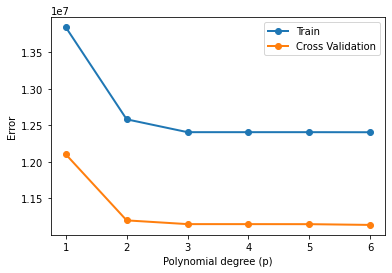

In [32]:
#p_vec, error_train, error_val = degreeCurve(X, y, X_CV, y_CV)

pyplot.plot(p_vec, error_train, '-o', p_vec, error_val, '-o', lw=2)
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('Polynomial degree (p)')
pyplot.ylabel('Error')

print('p\t\tTrain Error\tValidation Error')
for i in range(len(p_vec)):
    print(' %f\t%f\t%f' % (p_vec[i], error_train[i], error_val[i]))

#### Selecting $\lambda$ using a cross validation set

We first need to normalize our features for the test, training and CV set

In [33]:
p = 3

X_not_norm__for_poly = np.array(X_not_norm).reshape(np.array(X_not_norm).size,1)
# Map X onto Polynomial Features 
X_not_norm_poly = polyFeatures(X_not_norm__for_poly, p)
print(X_not_norm_poly)

# normalize features
mu = np.mean(X_not_norm_poly, axis = 0)
sigma = np.std(X_not_norm_poly, axis = 0)
X_poly_norm = (X_not_norm_poly - mu) / sigma
print(X_poly_norm)
X_poly_norm_with_ones = np.concatenate([np.ones((m, 1)), X_poly_norm], axis=1)
print(X_poly_norm_with_ones)

#do the same for X_test
X_test = np.array(X_test).reshape(np.array(X_test).size,1)
X_poly_test = polyFeatures(X_test, p)
mu_poly_test = np.mean(X_poly_test, axis = 0)
sigma_poly_test = np.std(X_poly_test, axis = 0)
X_poly_test_norm = (X_poly_test - mu_poly_test) / sigma_poly_test
X_poly_test_norm_ones = np.concatenate([np.ones((m_test, 1)), X_poly_test_norm], axis=1) #concatenate ones

#do the same for X_CV
X_CV = np.array(X_CV).reshape(np.array(X_CV).size,1)
X_poly_CV = polyFeatures(X_CV, p)
mu_poly_CV = np.mean(X_poly_CV, axis = 0)
sigma_poly_CV = np.std(X_poly_CV, axis = 0)
X_poly_CV_norm = (X_poly_CV - mu_poly_CV) / sigma_poly_CV
X_poly_CV_norm_ones = np.concatenate([np.ones((m_CV, 1)), X_poly_CV_norm], axis=1) #concatenate ones


[[4.46200000e+03 1.99094440e+07 8.88359391e+10]
 [1.38730000e+04 1.92460129e+08 2.66999937e+12]
 [1.69150000e+04 2.86117225e+08 4.83967286e+12]
 ...
 [2.83800000e+03 8.05424400e+06 2.28579445e+10]
 [2.09000000e+03 4.36810000e+06 9.12932900e+09]
 [4.09930000e+04 1.68042605e+09 6.88857050e+13]]
[[-0.68945977 -0.4674334  -0.2921378 ]
 [ 0.08769827 -0.19012496 -0.22225168]
 [ 0.33890587 -0.03960743 -0.16350683]
 ...
 [-0.82356928 -0.48648605 -0.29392418]
 [-0.88533894 -0.4924101  -0.29429589]
 [ 2.32726111  2.20120436  1.57056734]]
[[ 1.         -0.68945977 -0.4674334  -0.2921378 ]
 [ 1.          0.08769827 -0.19012496 -0.22225168]
 [ 1.          0.33890587 -0.03960743 -0.16350683]
 ...
 [ 1.         -0.82356928 -0.48648605 -0.29392418]
 [ 1.         -0.88533894 -0.4924101  -0.29429589]
 [ 1.          2.32726111  2.20120436  1.57056734]]


lambda		Train Error	Validation Error
 0.000000	12408446.488026	11148916.206613
 0.001000	12408446.493294	11148896.254429
 0.003000	12408446.535420	11148856.387660
 0.010000	12408447.013916	11148717.238590
 0.030000	12408451.202577	11148323.093313
 0.100000	12408498.163271	11146982.355378
 0.300000	12408894.044323	11143468.812675
 1.000000	12412818.372963	11134340.680964
 3.000000	12436810.046220	11125926.238645
 10.000000	12544191.124017	11158190.855173


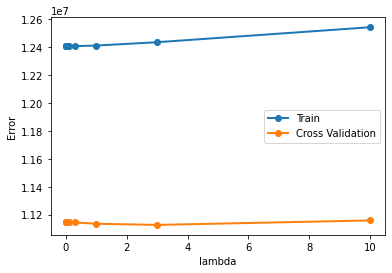

In [34]:
lambda_vec, error_train, error_val = validationCurve(X_poly_norm_with_ones, y, X_poly_CV_norm_ones, y_CV)

pyplot.plot(lambda_vec, error_train, '-o', lambda_vec, error_val, '-o', lw=2)
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('lambda')
pyplot.ylabel('Error')

print('lambda\t\tTrain Error\tValidation Error')
for i in range(len(lambda_vec)):
    print(' %f\t%f\t%f' % (lambda_vec[i], error_train[i], error_val[i]))

#### Polynomial regression with our chosen $\lambda$ 

[26586.69283066 -9997.06623117  9726.48541996 -3764.05121424]


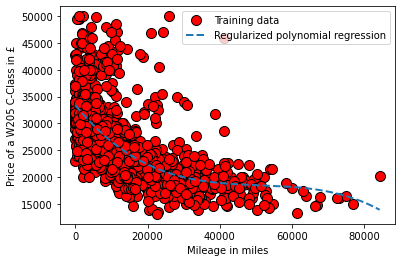

In [35]:
lambda_ = 0
theta_poly = trainLinearReg(linearRegCostFunction, X_poly_norm_with_ones, y,
                             lambda_=lambda_, maxiter=100000)
#theta_poly = theta_poly.reshape(1,-1)
#print(theta_poly.shape)
print(theta_poly)
h = hypothesis(X_poly_norm_with_ones[:,1].reshape(-1,1),theta_poly)
#print(h.tolist())

plotData(X_not_norm_stacked[:, 1], y)
#pyplot.plot(X_not_norm_stacked[:, 1], np.dot(X_poly_norm_with_ones, theta_poly), '-')
plotFit(polyFeatures, np.min(X_not_norm__for_poly), np.max(X_not_norm__for_poly), mu, sigma, theta_poly, p)
pyplot.legend(['Training data', 'Regularized polynomial regression']);
#print(hypothesis(X_not_norm_stacked[:,1], theta_poly))

Polynomial Regression (lambda = 0.000000)

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	159160971.094263
  	2		0.000000	322192473.836680
  	3		0.000000	16676064981.969225
  	4		0.000000	2006461100520.869141
  	5		657412.378916	101164241952.952728
  	6		580540.146632	4731552861.489203
  	7		623667.540132	4483282091.211056
  	8		13108114.640359	1980727405.454958
  	9		16824769.312861	408052402.891828
  	10		15222064.280598	273687655.731334
  	11		17522434.191856	124895229.088525
  	12		16185359.709752	201541639.983816
  	13		17241516.236363	149240581.008984
  	14		16534965.078435	99993780.749946
  	15		15992618.862079	26151402.475447
  	16		15358901.326937	21115069.023053
  	17		14459965.862725	21113041.050484
  	18		14390454.002646	18260015.182753
  	19		13666339.003805	18213675.733985
  	20		13360247.682767	17843938.097188
  	21		13504819.535223	17049209.192224
  	22		12910860.502343	18257829.242256
  	23		13026630.719208	20319354.586205
  	24		12512385.514646	

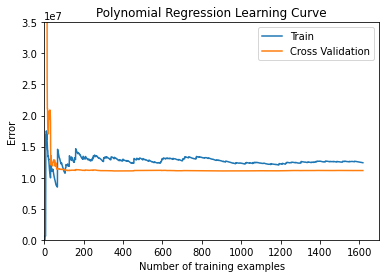

In [36]:
lambda_ = 0

pyplot.figure()
error_train_poly, error_val_poly = learningCurve(X_poly_norm_with_ones, y, X_poly_CV_norm_ones, y_CV, lambda_ )
pyplot.plot(np.arange(1, 1+m), error_train_poly, np.arange(1, 1+m), error_val_poly)

pyplot.title('Polynomial Regression Learning Curve')
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.axis([0, 1700, 0, 35000000])
pyplot.legend(['Train', 'Cross Validation'])

print('Polynomial Regression (lambda = %f)\n' % lambda_)
print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train_poly[i], error_val_poly[i]))

Determining the R² Value:

In [37]:
y_pred_poly = np.dot(X_poly_norm_with_ones, theta_poly)
#print(y_pred_poly)
#print(y)
print("R² for polynomial model:",r2_score(y, y_pred_poly))

R² for polynomial model: 0.43114542880627726


Price prediction:

In [38]:
X_prediction = [1, 75000, 75000**2, 75000**3] #for a car with 75 000 miles
X_prediction[1:4] = (X_prediction[1:4] - mu) / sigma
#print(np.array(X_prediction).shape)
price = np.dot(X_prediction, theta_poly)
print(price)

16430.074328546238


### Error histogram CV

[26165.62152134 -8817.55165759  7497.75501112 -2500.40930057]
[29405.42401168 28201.3429405  22563.4794537  29542.49581527
 30815.9374771  22134.43858392 28621.49875052 31953.27568379
 30631.01507574 23877.10324455 28261.75464592 22242.80403996
 23886.56587373 26201.20137558 22773.20565096 19816.03313277
 30274.23301077 29881.77224332 29758.32058972 32681.67726698
 21165.05269675 21037.06493855 18805.45207158 23758.51333773
 23298.89154198 21165.05269675 19436.25989882 19231.69868777
 21902.33639424 19531.95616291 29212.8225486  21906.70209921
 31953.27568379 27921.76322974 26226.1165369  18459.98524235
 25627.4946909  26681.32258255 24611.12176449 19073.94692492
 24115.68158533 24849.24335184 27410.99564611 19466.87970161
 24633.10700131 20528.18485363 30901.63157314 25065.05850722
 26637.61020375 32612.92683059 20927.00135087 24152.83140197
 20356.42425371 27188.00655441 24191.33713527 32674.19312925
 19418.23767485 22421.27569672 22670.08027836 31357.31476162
 27544.19039808 32613.6

(array([302., 151.,  48.,  18.,   9.,   4.,   6.,   0.,   0.,   1.]),
 array([1.23609757e+01, 2.75643430e+03, 5.50050763e+03, 8.24458096e+03,
        1.09886543e+04, 1.37327276e+04, 1.64768009e+04, 1.92208743e+04,
        2.19649476e+04, 2.47090209e+04, 2.74530943e+04]),
 <BarContainer object of 10 artists>)

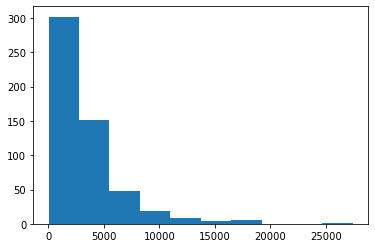

In [54]:
theta_poly_CV = trainLinearReg(linearRegCostFunction, X_poly_CV_norm_ones, y_CV,
                             lambda_=lambda_, maxiter=100000)
print(theta_poly_CV)
y_poly_pred_CV = np.dot(X_poly_CV_norm_ones, theta_poly_CV)
print(y_poly_pred_CV)
fout_poly_CV = np.abs(y_CV - y_poly_pred_CV)
pyplot.hist(fout_poly_CV)

# Price prediction of specific brand: Mercedes

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

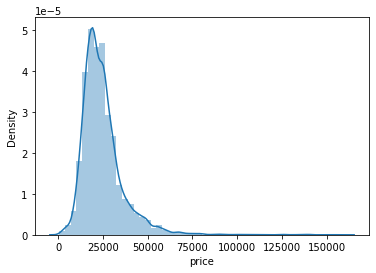

In [55]:
sbn.distplot(mercedes["price"])

Niet goed, we gaan proberen te filteren van 0-  60 000 :

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

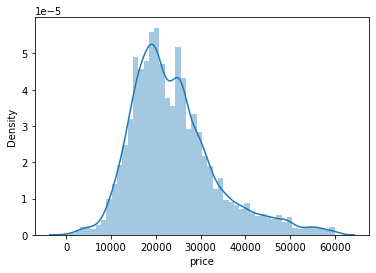

In [56]:
mercedes = mercedes.loc[(mercedes['price'] >= 0) & (mercedes['price'] <= 60000)]
sbn.distplot(mercedes["price"])

Data inladen en categorical variabelen fixen:

In [57]:
data_mercedes_expanded = pd.get_dummies(mercedes)
data_mercedes_expanded.drop('brand_mercedes', axis=1, inplace=True)
data_mercedes_expanded.head()

,year,price,mileage,tax,mpg,engineSize,model_ A Class,model_ B Class,model_ C Class,model_ CL Class,...,model_220,model_230,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,2005,5200,63000,325,32.1,1.8,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,2017,34948,27000,20,61.4,2.1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,2016,49948,6200,555,28.0,5.5,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
6,2018,30948,16000,145,47.9,2.1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
7,2012,10948,107000,265,36.7,3.5,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


Data normaliseren:

In [58]:
mercedes_expanded_numpy = data_mercedes_expanded.to_numpy()
print("Numpy dataset: \n",mercedes_expanded_numpy)
print("\nShape dataset: ",mercedes_expanded_numpy.shape)

mu_mercedes = np.mean(mercedes_expanded_numpy, axis=0)
#print(mu_mercedes)
sigma_mercedes = np.std(mercedes_expanded_numpy, axis=0)
#print(sigma_mercedes)
mercedes_expanded_numpy_norm = (mercedes_expanded_numpy - mu_mercedes) / sigma_mercedes
print("\nNormalized Mercedes dataset: \n",mercedes_expanded_numpy_norm)

Numpy dataset: 
 [[2.0050e+03 5.2000e+03 6.3000e+04 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [2.0170e+03 3.4948e+04 2.7000e+04 ... 1.0000e+00 0.0000e+00 0.0000e+00]
 [2.0160e+03 4.9948e+04 6.2000e+03 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 ...
 [2.0190e+03 3.0999e+04 1.1612e+04 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [2.0190e+03 3.7990e+04 2.4260e+03 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [2.0190e+03 5.4999e+04 2.0750e+03 ... 0.0000e+00 0.0000e+00 0.0000e+00]]

Shape dataset:  (12943, 41)

Normalized Mercedes dataset: 
 [[-5.5063881  -1.94899173  1.92461731 ... -0.1163932  -0.02326211
   1.61036689]
 [-0.12362107  1.14474363  0.22662574 ...  8.59156731 -0.02326211
  -0.6209765 ]
 [-0.57218499  2.70471507 -0.75443605 ... -0.1163932  -0.02326211
   1.61036689]
 ...
 [ 0.77350677  0.73405515 -0.49917132 ... -0.1163932  -0.02326211
  -0.6209765 ]
 [ 0.77350677  1.46110583 -0.93244217 ... -0.1163932  -0.02326211
  -0.6209765 ]
 [ 0.77350677  3.23000945 -0.94899759 ... -0.1163932  -0.02326211
  

Selecting how much features and which features to be selected:

In [59]:
column_names_mercedes = data_mercedes_expanded.drop(columns = ['price']).columns
print(column_names_mercedes)

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'model_ A Class',
       'model_ B Class', 'model_ C Class', 'model_ CL Class',
       'model_ CLA Class', 'model_ CLC Class', 'model_ CLK',
       'model_ CLS Class', 'model_ E Class', 'model_ G Class',
       'model_ GL Class', 'model_ GLA Class', 'model_ GLB Class',
       'model_ GLC Class', 'model_ GLE Class', 'model_ GLS Class',
       'model_ M Class', 'model_ R Class', 'model_ S Class', 'model_ SL CLASS',
       'model_ SLK', 'model_ V Class', 'model_ X-CLASS', 'model_180',
       'model_200', 'model_220', 'model_230', 'transmission_Automatic',
       'transmission_Manual', 'transmission_Other', 'transmission_Semi-Auto',
       'fuelType_Diesel', 'fuelType_Hybrid', 'fuelType_Other',
       'fuelType_Petrol'],
      dtype='object')


(12943, 40)
(12943,)
(12943, 41)


Text(0.5, 0, 'number of features')

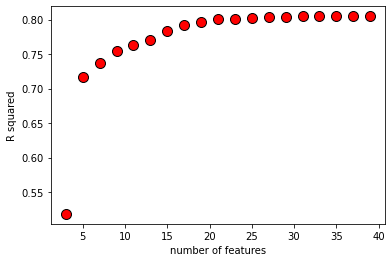

In [80]:
#data
X_mercedes = np.delete(mercedes_expanded_numpy_norm, 1, axis=1)
y_mercedes = mercedes_expanded_numpy_norm[:,1]
y_mercedes_not_norm = mercedes_expanded_numpy[:,1]
print(X_mercedes.shape)
print(y_mercedes.shape)
print(mercedes_expanded_numpy_norm.shape)


#for features
no_of_features = []
r_squared = []


for k in range(3, 40, 2):
    selector = SelectKBest(f_regression, k = k)
    X_transformed = selector.fit_transform(X_mercedes, y_mercedes)
    regressor = LinearRegression()
    regressor.fit(X_transformed, y_mercedes)
    no_of_features.append(k)
    teller = (1-(regressor.score(X_transformed, y_mercedes)))*(y_mercedes.size-1)
    noemer = y_mercedes.size-1
    r_squared.append(1-(teller/noemer))

fig = pyplot.figure()  # open a new figure    
pyplot.plot(no_of_features, r_squared, 'ro', ms=10, mec='k')
pyplot.ylabel('R squared')
pyplot.xlabel('number of features')   


In [61]:
selector = SelectKBest(f_regression, k = 20)
X_train_transformed = selector.fit_transform(X_mercedes, y_mercedes)
features_columns = column_names_mercedes[selector.get_support()]
print(features_columns.to_numpy().tolist())

['year', 'mileage', 'tax', 'mpg', 'engineSize', 'model_ A Class', 'model_ B Class', 'model_ E Class', 'model_ GLA Class', 'model_ GLC Class', 'model_ GLE Class', 'model_ GLS Class', 'model_ S Class', 'model_ SL CLASS', 'model_ SLK', 'model_ V Class', 'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Diesel', 'fuelType_Petrol']


In [62]:
data_mercedes_expanded_filtered = data_mercedes_expanded[features_columns.to_numpy().tolist()]
data_mercedes_expanded_filtered.head()

,year,mileage,tax,mpg,engineSize,model_ A Class,model_ B Class,model_ E Class,model_ GLA Class,model_ GLC Class,model_ GLE Class,model_ GLS Class,model_ S Class,model_ SL CLASS,model_ SLK,model_ V Class,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Petrol
0,2005,63000,325,32.1,1.8,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,2017,27000,20,61.4,2.1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2016,6200,555,28.0,5.5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
6,2018,16000,145,47.9,2.1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
7,2012,107000,265,36.7,3.5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


Normalise features and convert to numpy:

In [63]:
mercedes_expanded_goodfeatures_numpy = data_mercedes_expanded_filtered.to_numpy()
print(mercedes_expanded_goodfeatures_numpy)

#normalize
mu_mercedes_features = np.mean(mercedes_expanded_goodfeatures_numpy, axis=0)
#print(mu_mercedes)
sigma_mercedes_features = np.std(mercedes_expanded_goodfeatures_numpy, axis=0)
#print(sigma_mercedes)
mercedes_expanded_features_norm = (mercedes_expanded_goodfeatures_numpy - mu_mercedes_features) / sigma_mercedes_features
print("\nNormalized Mercedes dataset: \n",mercedes_expanded_features_norm)

[[2.0050e+03 6.3000e+04 3.2500e+02 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [2.0170e+03 2.7000e+04 2.0000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [2.0160e+03 6.2000e+03 5.5500e+02 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 ...
 [2.0190e+03 1.1612e+04 1.4500e+02 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [2.0190e+03 2.4260e+03 1.4500e+02 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [2.0190e+03 2.0750e+03 1.4500e+02 ... 0.0000e+00 1.0000e+00 0.0000e+00]]

Normalized Mercedes dataset: 
 [[-5.5063881   1.92461731  2.99362037 ... -1.04270993 -1.55636222
   1.61036689]
 [-0.12362107  0.22662574 -1.67964527 ... -1.04270993 -1.55636222
  -0.6209765 ]
 [-0.57218499 -0.75443605  6.51772233 ... -1.04270993 -1.55636222
   1.61036689]
 ...
 [ 0.77350677 -0.49917132  0.23562754 ... -1.04270993  0.64252395
  -0.6209765 ]
 [ 0.77350677 -0.93244217  0.23562754 ... -1.04270993  0.64252395
  -0.6209765 ]
 [ 0.77350677 -0.94899759  0.23562754 ... -1.04270993  0.64252395
  -0.6209765 ]]


Paste 1's before continueing:

In [64]:
m_merc = y_mercedes.size #dataset size
X_multi_not_norm = np.concatenate([np.ones((m_merc, 1)), mercedes_expanded_goodfeatures_numpy], axis=1)
X_multi_merc = np.concatenate([np.ones((m_merc, 1)), mercedes_expanded_features_norm], axis=1)
print(X_multi_merc)
#print(mercedes_expanded_features_norm.shape)
#print(m_merc)


[[ 1.         -5.5063881   1.92461731 ... -1.04270993 -1.55636222
   1.61036689]
 [ 1.         -0.12362107  0.22662574 ... -1.04270993 -1.55636222
  -0.6209765 ]
 [ 1.         -0.57218499 -0.75443605 ... -1.04270993 -1.55636222
   1.61036689]
 ...
 [ 1.          0.77350677 -0.49917132 ... -1.04270993  0.64252395
  -0.6209765 ]
 [ 1.          0.77350677 -0.93244217 ... -1.04270993  0.64252395
  -0.6209765 ]
 [ 1.          0.77350677 -0.94899759 ... -1.04270993  0.64252395
  -0.6209765 ]]


Some functions to compute cost and gradient descent for multiple features:

In [65]:
def computeCostMulti(X, y, theta):
    """
    Compute cost for linear regression with multiple variables.
    Computes the cost of using theta as the parameter for linear regression to fit the data points in X and y.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n+1).
    
    y : array_like
        A vector of shape (m, ) for the values at a given data point.
    
    theta : array_like
        The linear regression parameters. A vector of shape (n+1, )
    
    Returns
    -------
    J : float
        The value of the cost function. 
    
    Instructions
    ------------
    Compute the cost of a particular choice of theta. You should set J to the cost.
    """
    # Initialize some useful values
    m = y.shape[0] # number of training examples
    
    # You need to return the following variable correctly
    J = 0
    
    # ======================= YOUR CODE HERE ===========================
    h = np.dot(X, theta)
    
    J = (1/(2 * m)) * np.sum(np.square(np.dot(X, theta) - y))

    # ==================================================================
    return J

def gradientDescentMulti(X, y, theta, alpha, num_iters):
    """
    Performs gradient descent to learn theta.
    Updates theta by taking num_iters gradient steps with learning rate alpha.
        
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n+1).
    
    y : array_like
        A vector of shape (m, ) for the values at a given data point.
    
    theta : array_like
        The linear regression parameters. A vector of shape (n+1, )
    
    alpha : float
        The learning rate for gradient descent. 
    
    num_iters : int
        The number of iterations to run gradient descent. 
    
    Returns
    -------
    theta : array_like
        The learned linear regression parameters. A vector of shape (n+1, ).
    
    J_history : list
        A python list for the values of the cost function after each iteration.
    
    Instructions
    ------------
    Peform a single gradient step on the parameter vector theta.

    While debugging, it can be useful to print out the values of 
    the cost function (computeCost) and gradient here.
    """
    # Initialize some useful values
    m = y.shape[0] # number of training examples
    
    # make a copy of theta, which will be updated by gradient descent
    theta = theta.copy()
    
    J_history = []
    
    for i in range(num_iters):
        # ======================= YOUR CODE HERE ==========================

        theta = theta - (alpha / m) * (np.dot(X, theta) - y).dot(X)
        # =================================================================
        
        # save the cost J in every iteration
        J_history.append(computeCostMulti(X, y, theta))
    
    return theta, J_history


In [81]:
"""
# initialize fitting parameters
theta_multivariate_merc = np.zeros(26)

# some gradient descent settings
iterations = 100000
alpha = 0.1

theta_multivariate_merc, J_history_multi = gradientDescentMulti(X_multi_merc ,y_mercedes, theta_multivariate_merc, alpha, iterations)
print('Theta found by gradient descent: {:.4f}, {:.4f}'.format(*theta_multivariate_merc))

lambda_ = 0
theta_multi = trainLinearReg(computeCostMulti, X_multi_merc, y_mercedes,
                             lambda_=lambda_, maxiter=1000)
print(theta_multi)
"""


# Choose some alpha value - change this
alpha = 0.01
num_iters = 200

# init theta and run gradient descent
theta_multi = np.zeros(21)
theta_multi, J_history = gradientDescentMulti(X_multi_merc, y_mercedes_not_norm, theta_multi, alpha, num_iters)
print(theta_multi)


[20733.08796152  3269.99932676 -2812.16639699   225.9118981
 -1321.52302872  2437.85811083  -935.13450911  -751.65248853
   423.20288527  -617.69973578  1190.62708394  1682.67485269
   768.01937342  1008.38075077   195.63603179  -247.08330442
   733.56991268  -779.25188244   254.00879727  -410.71242857
    48.63477486]


19216.746926106563


Text(0, 0.5, 'Cost J')

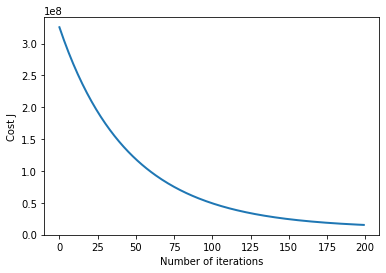

In [82]:
#['year', 'mileage', 'tax', 'mpg', 'engineSize', 'model_ A Class', 
#'model_ B Class', 'model_ E Class', 'model_ GLA Class', 'model_ GLC Class', 
#'model_ GLE Class', 'model_ GLS Class', 'model_ S Class', 
#'model_ SL CLASS', 'model_ SLK', 'model_ V Class', 
#'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Diesel', 
#'fuelType_Petrol']
X_prediction = [1, 2019, 9573, 145, 45.6, 1.3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] 
X_prediction[1:21] = (X_prediction[1:21] - mu_mercedes_features) / sigma_mercedes_features
#print(np.array(X_prediction).shape)
price = np.dot(X_prediction, theta_multi)
print(price)

pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
pyplot.xlabel('Number of iterations')
pyplot.ylabel('Cost J')

In [68]:
def regression_model(model):
    regressor = model
    regressor.fit(X_multi_merc, y_mercedes)
    score = regressor.score(X_multi_merc, y_mercedes)
    return regressor, score

In [90]:
#regressor, score = regression_model(LinearRegression())

y_pred = np.dot(X_multi_merc, theta_multi)
score = r2_score(y_mercedes_not_norm, y_pred)


print(score)

[-3559.50303491 28402.32789049 42804.13872468 ... 30217.63168176
 26010.26037829 38695.62678945]
0.6693308799696075


#### Error histogram

[ 5200. 34948. 49948. ... 30999. 37990. 54999.]


(array([1.1442e+04, 1.3100e+03, 1.6000e+02, 2.9000e+01, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([5.60503048e-02, 8.05837542e+03, 1.61166948e+04, 2.41750141e+04,
        3.22333335e+04, 4.02916529e+04, 4.83499722e+04, 5.64082916e+04,
        6.44666110e+04, 7.25249303e+04, 8.05832497e+04]),
 <BarContainer object of 10 artists>)

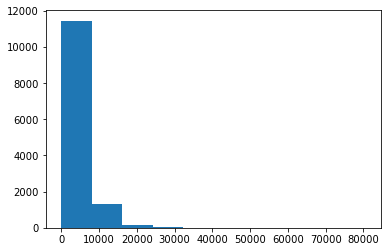

In [91]:
#error = np.abs(y_pred - y_mercedes)
#print(error)
#pyplot.hist(error)

print(y_mercedes_not_norm)
error = np.abs(y_mercedes_not_norm - y_pred)
pyplot.hist(error)

In [77]:
def normalEqn(X, y):
    """
    Computes the closed-form solution to linear regression using the normal equations.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n+1).
    
    y : array_like
        The value at each data point. A vector of shape (m, ).
    
    Returns
    -------
    theta : array_like
        Estimated linear regression parameters. A vector of shape (n+1, ).
    
    Instructions
    ------------
    Complete the code to compute the closed form solution to linear
    regression and put the result in theta.
    
    Hint
    ----
    Look up the function `np.linalg.pinv` for computing matrix inverse.
    """
    theta = np.zeros(X.shape[1])
    
    # ===================== YOUR CODE HERE ============================
    theta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),y)
    
    # =================================================================
    return theta

In [79]:
# Calculate the parameters from the normal equation
theta = normalEqn(X_multi_not_norm, mercedes_expanded_numpy[:,1]);

# Display normal equation's result
print(theta);

# Estimate the price of a 1650 sq-ft, 3 br house
# ====================== YOUR CODE HERE ======================

#['year', 'mileage', 'tax', 'mpg', 'engineSize', 'model_ A Class', 
#'model_ B Class', 'model_ E Class', 'model_ GLA Class', 'model_ GLC Class', 
#'model_ GLE Class', 'model_ GLS Class', 'model_ S Class', 
#'model_ SL CLASS', 'model_ SLK', 'model_ V Class', 
#'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Diesel', 
#'fuelType_Petrol']

X_prediction = [1, 2019, 9573, 145, 45.6, 1.3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] 
#X_prediction[1:21] = (X_prediction[1:21] - mu_mercedes_features) / sigma_mercedes_features
price = np.dot(X_prediction, theta) # You should change this

# ============================================================

print(price)

[-3.55339445e+06  1.77941186e+03 -1.27684107e-01 -7.05802607e+00
 -1.61226057e+02  5.69979828e+03 -1.33640130e+03 -3.13626629e+03
  1.75244068e+03 -2.03047362e+03  4.78378573e+03  8.97940409e+03
  1.04959230e+04  9.04421473e+03  1.65176930e+03  1.35389300e+03
  5.57469664e+03 -1.96146928e+03  9.29681907e+01 -1.19063327e+04
 -1.17487145e+04]
22165.202993260697
